In [1]:
import os
import copy
import numpy as np
import pandas as pd
import seaborn

from IFdensity.contam_sm_de import *
from IFdensity.influence_function import *

from IPython.display import Markdown as md

In [2]:
os.chdir('/Users/chenxizhou/Dropbox/code_package/IFdensity')
true_data = np.load('data/geyser.npy').astype(np.float64)
df = copy.deepcopy(true_data[:, 0]).reshape(-1, 1)

# original data with 108.0 removed 
data_waiting = df[df != 108.0]

# bandwidth parameter in the Gaussian kernel function
bw = 5.0

# penalty parameter 
log_pen_param = -12.0

# base density 
base_density = BasedenGamma(np.load('data/geyser.npy').astype(np.float64)[:, 0])

plot_kwargs = plot_IF_1d_params(x_limit=(21., 410.), plot_pts_cnt = 2000)

--------------------------------------------------
Current contaminated data point is 250.0.


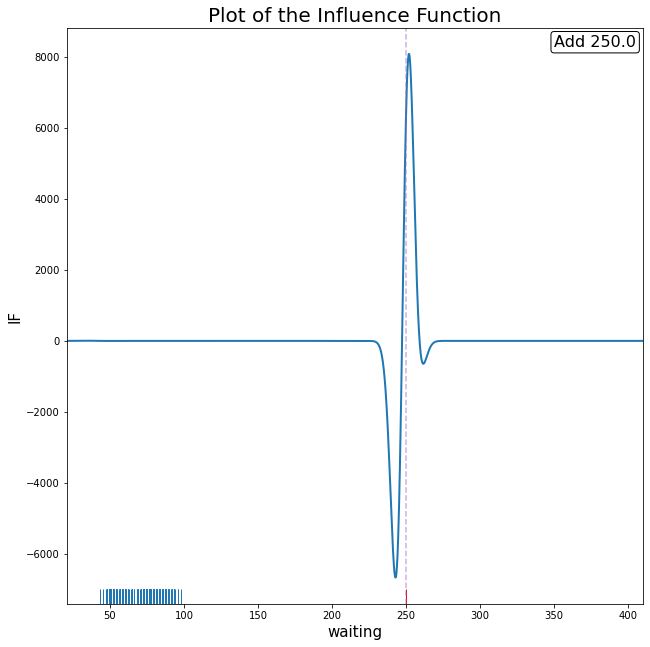

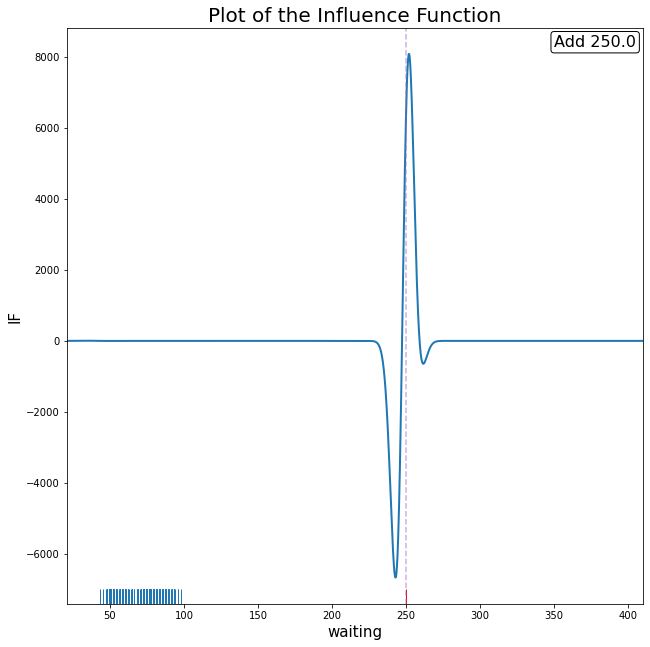

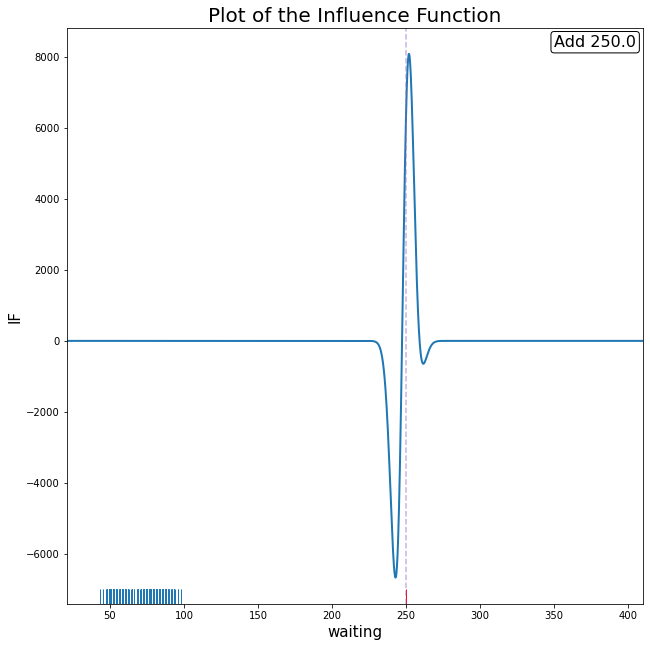

In [3]:
# contaminated data 
contam_data_list = np.array([250.]) # np.arange(., 410., 10)
for contam_pt in contam_data_list: 
    
    print('-' * 50)
    print(f'Current contaminated data point is {contam_pt}.')
    
    contam_data = np.array([[contam_pt]])
    
    ifun = SMInfluenceFunction(
        data = data_waiting, 
        contam_data = contam_data, 
        contam_weight = 1e-8, 
        penalty_param = np.exp(log_pen_param), 
        base_density = base_density, 
        bw = bw)
    
    if_vals0 = ifun.plot_IF_logdensity_1d(
        plot_kwargs = plot_kwargs, 
        x_label = 'waiting')
    
    if_vals = ifun.plot_IF_natparam_1d(
        plot_kwargs = plot_kwargs, 
        x_label = 'waiting')
    
    if_vals1 = ifun.plot_IF_natparam_limit_1d(
        plot_kwargs = plot_kwargs, 
        x_label = 'waiting')
    

In [ ]:
if_vals0

In [ ]:
np.sort(np.unique(data_waiting.flatten())).shape

In [ ]:
data_waiting_pur = data_waiting.flatten() + np.random.randn(len(data_waiting)) / 10.
data_waiting_pur

In [ ]:
np.max(np.abs(data_waiting - data_waiting_pur))

In [ ]:
# contaminated data 
contam_data_list = np.array([10250.]) # np.arange(., 410., 10)
for contam_pt in contam_data_list: 
    
    print('-' * 50)
    print(f'Current contaminated data point is {contam_pt}.')
    
    contam_data = np.array([[contam_pt]])
    
    ifun = SMInfluenceFunction(
        data = data_waiting, 
        contam_data = contam_data, 
        contam_weight = 1e-8, 
        penalty_param = np.exp(log_pen_param), 
        base_density = base_density, 
        bw = bw)
    
    if_vals = ifun.plot_IF_logdensity_1d(
        plot_kwargs = plot_kwargs, 
        x_label = 'waiting')
    

In [ ]:
def converge(contam_data, kernel_function, base_density, penalty_param, newx): 
    
    newx = newx.reshape(-1, 1)
    log_bd = base_density.logbaseden_deriv1(new_data = contam_data, j = 0)
    kernel_y_10 = kernel_function.partial_kernel_matrix_10(new_data = newx)
    kernel_y_20 = kernel_function.partial_kernel_matrix_20(new_data = newx)
    
    output = -(log_bd * kernel_y_10 + kernel_y_20) / penalty_param
    
    return output
    
    

In [ ]:
contam_pt = 10250.
kf = GaussianPoly2(
    data=np.array([[contam_pt]]),
    r1=1.0,
    r2=0.,
    c=0,
    bw=5.0)

In [ ]:
result = converge(
    contam_data = np.array([[contam_pt]]), 
    kernel_function = kf, 
    base_density = base_density, 
    penalty_param = np.exp(log_pen_param), 
    newx = np.linspace(plot_kwargs['x_limit'][0], plot_kwargs['x_limit'][1], plot_kwargs['plot_pts_cnt']))

In [ ]:
plt.plot(np.linspace(plot_kwargs['x_limit'][0], plot_kwargs['x_limit'][1], plot_kwargs['plot_pts_cnt']), result.flatten())